# Adversarial Validation

Given that the train and test sets from the kaggle competition come from different points in time, it's clear that the train and test distributions are different. With an adversarial validation model, including the transaction_dt as a feature provides an auc_score of 1.0, however once you remove that feature, there is still an auc_score of .9 or so. This means that the train and test distributions are still fundamentally different.

Knowing that, is there anything that should be done about it? In this particular dataset, given the different temporal distribution between train and test, it doesn't seem that trying to find training examples which look like test examples and then using those as the validation set would be useful.

Aside from perhaps dropping features which are the most important in the adversarial validation model, or perhaps editing features to remove any date-related information from them, I'm not sure what else we'd want to do here.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import os
import pathlib

sns.set()
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

from trav_lib.visualize import plot_correlation_matrix_heat_map
from trav_lib.evaluate import get_confusion_matrix, evaluate_model
from trav_lib.utility import output_model

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_dir = pathlib.Path().resolve().parent / 'data'

data_raw = data_dir / 'raw'
data_interim = data_dir / 'interim'
data_external = data_dir / 'external'
data_processed = data_dir / 'processed'

model_dir = pathlib.Path().resolve().parent / 'models'

In [3]:
train = pd.read_parquet(data_interim / 'train.parquet')
test = pd.read_parquet(data_interim / 'test.parquet')

In [4]:
target_col = 'is_fraud'
date_col = 'transaction_dt'
trans_cat_cols = ['product_cd','card1','card2','card3','card4','card5','card6','addr1','addr2',
                  'p_emaildomain','r_emaildomain','m1','m2','m3','m4','m5','m6','m7','m8','m9']
trans_num_cols = list(train.loc[:,:'v339'].columns.drop([target_col] + trans_cat_cols + [date_col]))

ident_cat_cols = list(train.loc[:,'id_12':'identity_match'].columns)
ident_num_cols = list(train.loc[:,'id_01':'id_11'].columns)

cat_cols = trans_cat_cols + ident_cat_cols
num_cols = trans_num_cols + ident_num_cols

In [5]:
vcols = list(train.loc[:,'v1':'v339'].columns)

## Build model

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.model_selection import ParameterGrid, ParameterSampler, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, make_scorer

In [7]:
import xgboost as xgb
from xgboost import XGBClassifier

In [8]:
roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [9]:
def group_values(s, top_n = 10, other_name = 'other'):

    counts = s.value_counts(dropna=False)
    if len(counts) > top_n:
        counts = counts.iloc[:top_n]
        usevals = list(counts.index)

        s = pd.Series(np.where(s.isin(usevals), s, other_name), index=s.index)

    return(s)

def group_values_df(df, top_n = 10, other_name = 'other'):
    
    df2 = df.copy()
    
    for col in df2.columns:
        df2[col] = group_values(df2[col], top_n, other_name)
        
    return(df2)

group_transformer = FunctionTransformer(group_values_df) 

# Combine train and test set & add new target feature (test_set)

In [12]:
df = pd.concat([train.drop('is_fraud',axis=1),test])

In [13]:
df.head()

,transaction_dt,transaction_amt,product_cd,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,p_emaildomain,r_emaildomain,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,m1,m2,m3,m4,m5,m6,m7,m8,m9,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131,v132,v133,v134,v135,v136,v137,v138,v139,v140,v141,v142,v143,v144,v145,v146,v147,v148,v149,v150,v151,v152,v153,v154,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v214,v215,v216,v217,v218,v219,v220,v221,v222,v223,v224,v225,v226,v227,v228,v229,v230,v231,v232,v233,v234,v235,v236,v237,v238,v239,v240,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v251,v252,v253,v254,v255,v256,v257,v258,v259,v260,v261,v262,v263,v264,v265,v266,v267,v268,v269,v270,v271,v272,v273,v274,v275,v276,v277,v278,v279,v280,v281,v282,v283,v284,v285,v286,v287,v288,v289,v290,v291,v292,v293,v294,v295,v296,v297,v298,v299,v300,v301,v302,v303,v304,v305,v306,v307,v308,v309,v310,v311,v312,v313,v314,v315,v316,v317,v318,v319,v320,v321,v322,v323,v324,v325,v326,v327,v328,v329,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,device_type,device_info,identity_match
transaction_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,nan,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,nan,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,nan,nan,nan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [17]:
df['test_set'] = 1
df['test_set'].loc[train.index] = 0

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
df['test_set'].value_counts()

0    590540
1    506691
Name: test_set, dtype: int64

# Train and evaluate models

In [51]:
usecols = num_cols + cat_cols

X = df[usecols]
y = df['test_set']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [52]:
%%time

group_transformer = FunctionTransformer(group_values_df, kw_args={'top_n':10}) 

cat_pipe = Pipeline([
    ('grouping',group_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

use_num_cols = [col for col in num_cols if col in X.columns]
use_cat_cols = [col for col in cat_cols if col in X.columns]

transformers = [('cat',cat_pipe,use_cat_cols)]

preprocessor = ColumnTransformer(transformers, remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(n_estimators = 100, learning_rate = .1, verbosity=0, use_label_encoder=False,
                          eval_metric='auc', tree_method='hist',
                          colsample_bytree = .9, colsample_bylevel=.7, max_depth=20,
                          min_child_weight = 50, subsample = 0.9))
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

model = XGBClassifier(n_estimators = 20, learning_rate = .1, verbosity=1, use_label_encoder=False,
                      eval_metric='auc', tree_method='hist',
                      colsample_bytree = .9, colsample_bylevel=.7, max_depth=20,
                      min_child_weight = 50, subsample = 0.9)

Wall time: 36.9 s


In [53]:
%%time
model.fit(X_train_processed, y_train,
          verbose=True, 
          eval_set = [(X_train_processed, y_train),
                      (X_test_processed, y_test)], 
          eval_metric = 'auc')

[0]	validation_0-auc:0.88317	validation_1-auc:0.87782
[1]	validation_0-auc:0.88857	validation_1-auc:0.88344
[2]	validation_0-auc:0.89273	validation_1-auc:0.88783
[3]	validation_0-auc:0.89445	validation_1-auc:0.88958
[4]	validation_0-auc:0.89545	validation_1-auc:0.89052
[5]	validation_0-auc:0.89751	validation_1-auc:0.89232
[6]	validation_0-auc:0.89850	validation_1-auc:0.89316
[7]	validation_0-auc:0.89903	validation_1-auc:0.89360
[8]	validation_0-auc:0.89995	validation_1-auc:0.89427
[9]	validation_0-auc:0.90110	validation_1-auc:0.89512
[10]	validation_0-auc:0.90232	validation_1-auc:0.89611
[11]	validation_0-auc:0.90294	validation_1-auc:0.89653
[12]	validation_0-auc:0.90368	validation_1-auc:0.89716
[13]	validation_0-auc:0.90440	validation_1-auc:0.89787
[14]	validation_0-auc:0.90497	validation_1-auc:0.89834
[15]	validation_0-auc:0.90557	validation_1-auc:0.89877
[16]	validation_0-auc:0.90597	validation_1-auc:0.89910
[17]	validation_0-auc:0.90651	validation_1-auc:0.89953
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=20, min_child_weight=50, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [64]:
enc = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feats = enc.get_feature_names(cat_cols)

In [69]:
cols1 = num_cols + list(cat_feats)

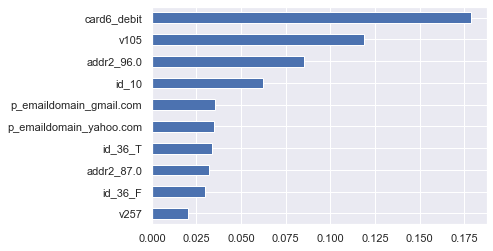

In [70]:
feature_importances = pd.Series(model.feature_importances_, index = cols1)
feature_importances = feature_importances.sort_values(ascending=False)

feature_importances.head(10).sort_values().plot.barh()

In [74]:
df.groupby('test_set')['v105'].describe()

,count,mean,std,min,25%,50%,75%,max
test_set,,,,,,,,
0,590226.0,0.281145,3.373978,0.0,0.0,0.0,0.0,99.0
1,506691.0,0.188436,1.494507,0.0,0.0,0.0,0.0,99.0


In [71]:
df['card6'].value_counts()

debit              824959
credit             267648
nan                  4578
debit or credit        30
charge card            16
Name: card6, dtype: int64

In [72]:
pd.crosstab(df['card6'], df['test_set'])

test_set,0,1
card6,,
charge card,15,1
credit,148986,118662
debit,439938,385021
debit or credit,30,0
nan,1571,3007
